# Intro

The assignment is to create a model in the Kaggle competition "Histopathologic Cancer Detection" that can correctly label malignant tumors vs non-malignant ones in the given set of images. We are given a train and test split of data in the competition where the training data has labels (0 or 1) for whether the tumor is cancerous or not. 

There are roughly 250,000 data images between the train and test splits, the images are 32x32px, and it will require some initial setup to make the files usable.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
tl = pd.read_csv('train_labels.csv')
ss = pd.read_csv('sample_submission.csv')

In [3]:
trainimagesdir = 'Downloads/histopathologic-cancer-detection/train'
testimagesdir = 'Downloads/histopathologic-cancer-detection/test'

In [4]:
train_img = os.listdir(trainimagesdir)
test_img = os.listdir(testimagesdir)

The very first thing to do is load in all the packages, read in the files. and set the directories on my computer so that I can use the files.

In [5]:
tl.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


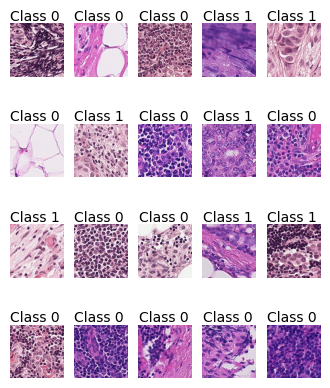

In [6]:
sample = tl.sample(n=20).reset_index()

plt.figure(figsize=(4,5))

for i, row in sample.iterrows():

    img = mpimg.imread(f'{trainimagesdir}/{row.id}.tif') # add .tif to the images so they can be read and appear below properly 
    label = row.label

    plt.subplot(4,5,i+1)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')
        
    plt.axis('off')
    
plt.show()

# EDA

As can be seen, the data is image files, but we will need to add the .tif file ending to actually see them, otherwise we just have the id column shown with the head() function. As for further EDA, the only real helpful thing would be to see if there are any unclassified images if the dataset was unknown, but that is not the case. 

Based off the EDA, adding the .tif file ending is a must, but beyond that it is possible to build the model from here.

In [7]:
train, test = train_test_split(tl, test_size=0.25, random_state=17, stratify=tl.label)

print(train.shape)
print(test.shape)

(165018, 2)
(55007, 2)


In [8]:
train_idg = ImageDataGenerator(
    rescale=1/255,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    vertical_flip=True,
    fill_mode='nearest'
)

test_idg = ImageDataGenerator(rescale=1/255)

train['label'] = train['label'].astype(str)
test['label'] = test['label'].astype(str)

In [9]:
train['id'] = train['id'] + '.tif'
test['id'] = test['id'] + '.tif'

In [10]:
train_gen = train_idg.flow_from_dataframe(
    dataframe=train,
    directory=trainimagesdir,
    x_col='id',
    y_col='label',
    target_size=(32, 32),
    batch_size=16,
    class_mode='categorical'
)

test_gen = test_idg.flow_from_dataframe(
    dataframe=test,
    directory=trainimagesdir,
    x_col='id',
    y_col='label',
    target_size=(32, 32),
    batch_size=16,
    class_mode='categorical'
)

Found 165018 validated image filenames belonging to 2 classes.
Found 55007 validated image filenames belonging to 2 classes.


In [11]:
model = Sequential([
    
    Conv2D(16, (3,3), activation = 'relu', padding = 'same', input_shape=(32, 32, 3)),
    Conv2D(16, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    BatchNormalization(),

    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    BatchNormalization(),
    
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    BatchNormalization(),

    Flatten(),
    
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

# Model Description

We use 3x3 kernals in the model above, as well as the relu activation function except after running batch normalization at the very end. We try to use dropout to help prevent overfitting, but at least for the below model it seems that it failed. I thought this was a resonable starting point to put together 3 different layers (although 6 in total) with a relu activation function. After running this model I then researched other types of activation functions to try later in the project. 

In [12]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.003, beta_1=0.91)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

# Model Results

This below model is possibly overfitting. The validation accuracy decreases significantly with each epoch after the first one while the training accuracy goes up. The fifth epoch the validation actually improved, but unfortunately the 6th epoch would not complete on my computer.

In [22]:
#train_gen_len = len(train_gen)
#test_gen_len = len(test_gen)

#h1 = model.fit(
#    train_gen,
#    steps_per_epoch = train_gen_len,
#    epochs=6,
#    validation_data=test_gen, 
#    validation_steps = test_gen_len, 
#    verbose=1)

In [14]:
train_gen1 = train_idg.flow_from_dataframe(
    dataframe=train,
    directory=trainimagesdir,
    x_col='id',
    y_col='label',
    target_size=(32, 32),
    batch_size=64,
    class_mode='categorical'
)

test_gen1 = test_idg.flow_from_dataframe(
    dataframe=test,
    directory=trainimagesdir,
    x_col='id',
    y_col='label',
    target_size=(32, 32),
    batch_size=64,
    class_mode='categorical'
)

Found 165018 validated image filenames belonging to 2 classes.
Found 55007 validated image filenames belonging to 2 classes.


In [15]:
model1 = Sequential([
    
    Conv2D(16, (3,3), activation = 'leaky_relu', padding = 'same', input_shape=(32, 32, 3)),
    Conv2D(16, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    BatchNormalization(),

    Conv2D(32, (3,3), activation = 'leaky_relu', padding = 'same'),
    Conv2D(32, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    BatchNormalization(),
    
    Conv2D(64, (3,3), activation = 'leaky_relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    BatchNormalization(),

    Flatten(),
    
    Dense(64, activation='leaky_relu'),
    Dropout(0.4),
    Dense(32, activation='leaky_relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

# Model Reasoning + Hyperparameter tuning

I ran this model roughly 5 times tuning down the learning rate each time until I got a result that I was happy with (above .8 val accuracy & .9 auc). I chose not to tune other hyperparameters as this is a relatively new concept for me, so I wanted to dial in learning rate as much as possible. The other difference is that this uses the NADAM optimizer instead of ADAM and this is a different algorithm. The result produced below also appears to be better after tuning the learning rate.

In [20]:
opt = tf.keras.optimizers.experimental.Nadam(learning_rate = 0.0001, beta_1=0.91)
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [21]:
train_gen_len1 = len(train_gen1)
test_gen_len1 = len(test_gen1)

h2 = model1.fit(
    train_gen1,
    steps_per_epoch = train_gen_len1,
    epochs=5,
    validation_data=test_gen1, 
    validation_steps = test_gen_len1, 
    verbose=1)

Epoch 1/5
2579/2579 [==============================] - 240s 92ms/step - loss: 0.3414 - accuracy: 0.8538 - auc_3: 0.9265 - val_loss: 0.3287 - val_accuracy: 0.8595 - val_auc_3: 0.9306
Epoch 2/5
2579/2579 [==============================] - 264s 102ms/step - loss: 0.3386 - accuracy: 0.8547 - auc_3: 0.9278 - val_loss: 0.3109 - val_accuracy: 0.8701 - val_auc_3: 0.9374
Epoch 3/5
2579/2579 [==============================] - 285s 110ms/step - loss: 0.3372 - accuracy: 0.8564 - auc_3: 0.9283 - val_loss: 0.3796 - val_accuracy: 0.8356 - val_auc_3: 0.9120
Epoch 4/5
2579/2579 [==============================] - 319s 124ms/step - loss: 0.3357 - accuracy: 0.8572 - auc_3: 0.9290 - val_loss: 0.3136 - val_accuracy: 0.8670 - val_auc_3: 0.9362
Epoch 5/5
2579/2579 [==============================] - 281s 109ms/step - loss: 0.3334 - accuracy: 0.8574 - auc_3: 0.9298 - val_loss: 0.3119 - val_accuracy: 0.8689 - val_auc_3: 0.9370


# Conclusion

This model performs much better than the last model and it's also less computationally intensive, so this will be the model I use. Tuning the learning rate helped the model significantly; although I did find that when epochs are too large I run a risk of running out of space on my current CPU. This led to the first model crashing about 90% of the way through. I think in the future I will try to have more epochs with smaller sizes. 